In [1]:
# !git clone https://github.com/hssh18121/SegFormer-tf

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


In [3]:
%cd "SegFormer-tf"

/home/work2/Workspace/sonnh/do_an_test/SegFormer-tf


In [4]:
import os
import random
import glob
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from models import SegFormer_B3

2024-05-21 14:03:12.266765: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-21 14:03:12.433144: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-21 14:03:12.433171: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-21 14:03:12.433975: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-21 14:03:12.514159: I tensorflow/core/platform/cpu_feature_g

In [5]:
save_train_image_dataset_path = '../bk-isut-dataset/train_image_dataset.npy'
save_val_image_dataset_path = '../bk-isut-dataset/val_image_dataset.npy'
save_test_image_dataset_path = '../bk-isut-dataset/test_image_dataset.npy'
save_train_mask_image_dataset_path = '../bk-isut-dataset/mask_train_image_dataset.npy'
save_val_mask_image_dataset_path = '../bk-isut-dataset/mask_val_image_dataset.npy'
save_test_mask_image_dataset_path = '../bk-isut-dataset/mask_test_image_dataset.npy'

In [6]:
X_train = np.load(save_train_image_dataset_path, mmap_mode='c')
X_val = np.load(save_val_image_dataset_path, mmap_mode='c')
X_test = np.load(save_test_image_dataset_path, mmap_mode='c')
y_train = np.load(save_train_mask_image_dataset_path, mmap_mode='c')
y_val = np.load(save_val_mask_image_dataset_path, mmap_mode='c')
y_test = np.load(save_test_mask_image_dataset_path, mmap_mode='c')

In [7]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))

2024-05-21 14:03:15.561957: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-21 14:03:15.584449: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-21 14:03:15.584533: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [8]:
import albumentations as A

In [9]:
# Define the augmentation function
def round_clip_0_1(x, **kwargs):
    return x.round().clip(0, 1)

def get_training_augmentation(height, width):
    train_transform = [
        A.HorizontalFlip(p=0.5),
        A.ShiftScaleRotate(scale_limit=0.6, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0, value=0),
        A.PadIfNeeded(min_height=height, min_width=width, always_apply=True, border_mode=0, value=0),
        A.RandomCrop(height=height, width=width, always_apply=True),
        A.GaussNoise(p=0.2),
        A.Perspective(p=0.5),
        A.OneOf(
            [
                A.CLAHE(p=1),
                A.RandomBrightnessContrast(p=1),
                A.RandomGamma(p=1),
            ],
            p=0.9,
        ),
        A.OneOf(
            [
                A.Sharpen(p=1),
                A.Blur(blur_limit=3, p=1),
                A.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),
        A.OneOf(
            [
                A.RandomBrightnessContrast(p=1),
                A.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
        A.Lambda(mask=round_clip_0_1)
    ]
    return A.Compose(train_transform)

In [10]:
# Function to apply augmentation
def augment_data(image, mask):
    aug = get_training_augmentation(256, 256)(image=image, mask=mask)
    aug_image = aug['image'].astype(np.uint8)
    aug_mask = aug['mask'].astype(np.uint8)
    return aug_image, aug_mask

# Wrap the augmentation function for TensorFlow
def tf_augment_data(image, mask):
    aug_img, aug_mask = tf.numpy_function(func=augment_data, inp=[image, mask], Tout=[tf.uint8, tf.uint8])
    return aug_img, aug_mask

In [11]:
def _normalize(X_batch, y_batch):
  X_batch = tf.cast(X_batch, tf.float32)
  y_batch = tf.cast(y_batch, tf.float32)
  return X_batch, y_batch

In [12]:
# Create augmented dataset
augmented_train_dataset = train_dataset.map(tf_augment_data)

In [13]:
# Combine normal and augmented datasets
combined_train_dataset = train_dataset.concatenate(augmented_train_dataset)

In [14]:
# Normalize and batch the datasets
train_dataset = combined_train_dataset.map(_normalize).batch(32)
val_dataset = val_dataset.batch(32).map(_normalize)

In [15]:
os.environ["SM_FRAMEWORK"] = "tf.keras"

In [16]:
import segmentation_models as sm

Segmentation Models: using `tf.keras` framework.


In [17]:
checkpoint_path = "../augmented_segformer_B3_weights/cp.weights.h5"

In [18]:
model = SegFormer_B3(input_shape = (256,256,3), num_classes = 5)

In [19]:
model.compile('Adam', loss=sm.losses.dice_loss, metrics=[sm.metrics.iou_score],)

In [20]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=30, monitor='val_loss'),
    tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                             monitor='val_loss',
                                             save_best_only=True,
                                             save_weights_only=True,
                                             verbose=1)
]


# model = tf.keras.models.load_model('my_model_with_batch_image.keras')
history = model.fit(
   train_dataset,
   epochs=200,
   validation_data=val_dataset,
   callbacks=callbacks,
)

Epoch 1/200


2024-05-21 14:03:54.428030: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/seg_former_head/dropout_84/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-05-21 14:03:58.542507: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2024-05-21 14:03:59.035399: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7c0c7824e580 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-05-21 14:03:59.035420: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2024-05-21 14:03:59.110589: W tensorflow/compiler/xla/service/gpu/buffer_comparator.cc:1052] INTERNAL: ptxas exited with non-zero error code 65280, output: ptxas /tmp/tempfile-ngoc-Z790-D-DDR4-83696820-2224376-618f16c0ad436, line 10; fatal   : Unsupporte

183/390 [=============>................] - ETA: 51s - loss: 0.5587 - iou_score: 0.3395

In [ ]:
model.load_weights(checkpoint_path)

1/1 [==============================] - 0s 16ms/step


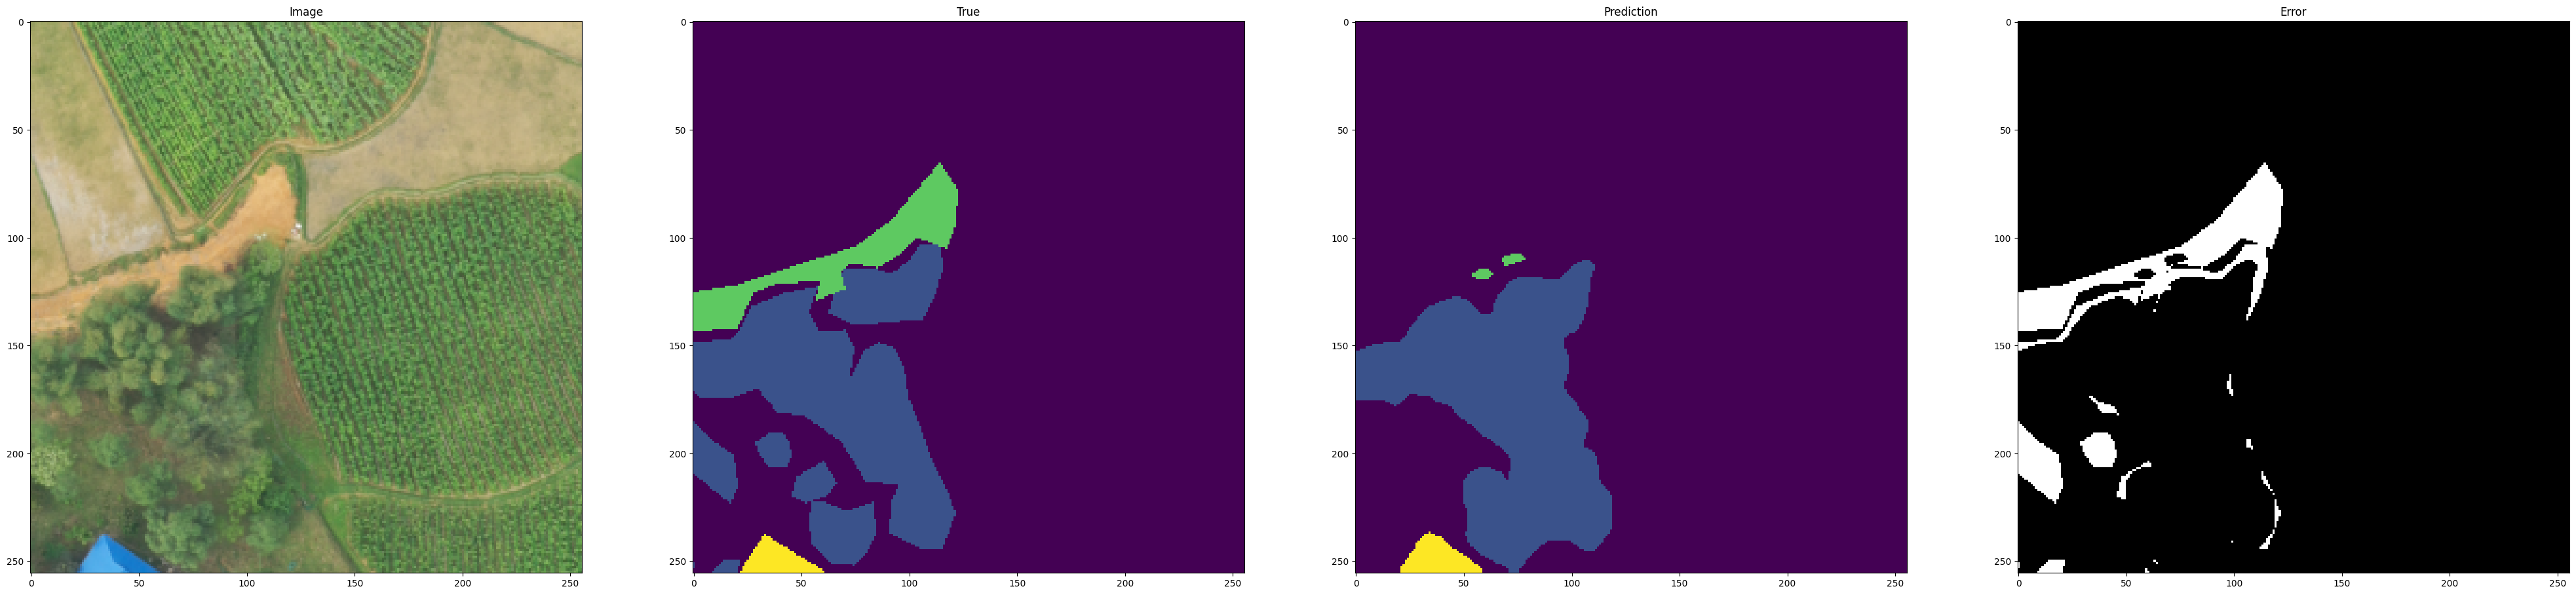

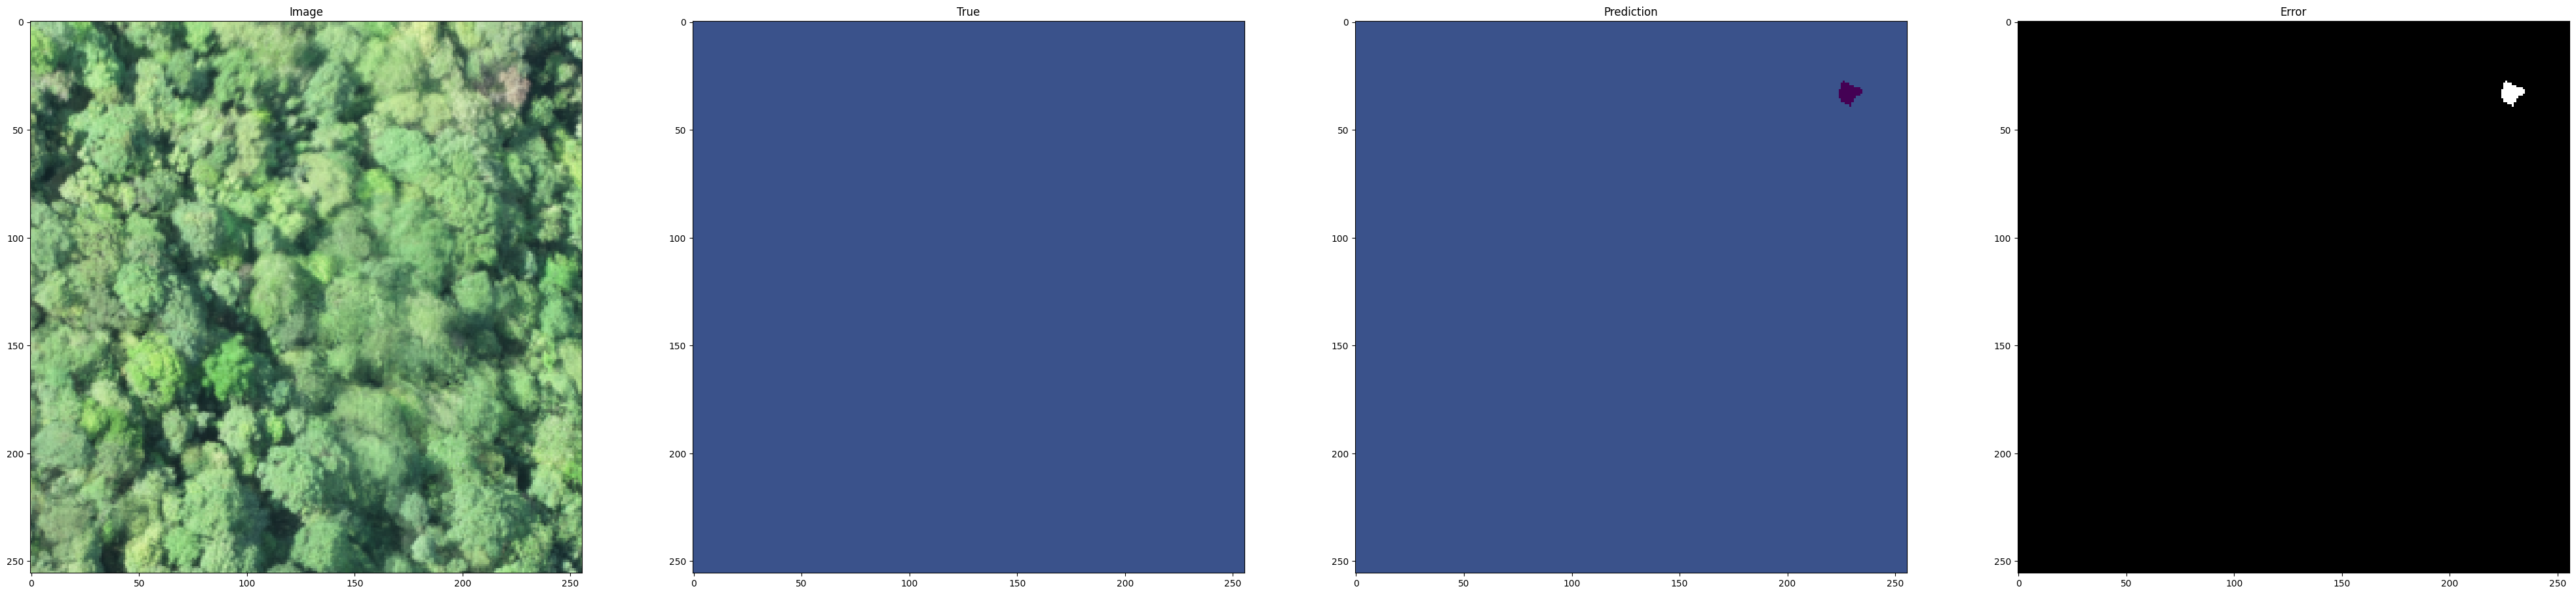

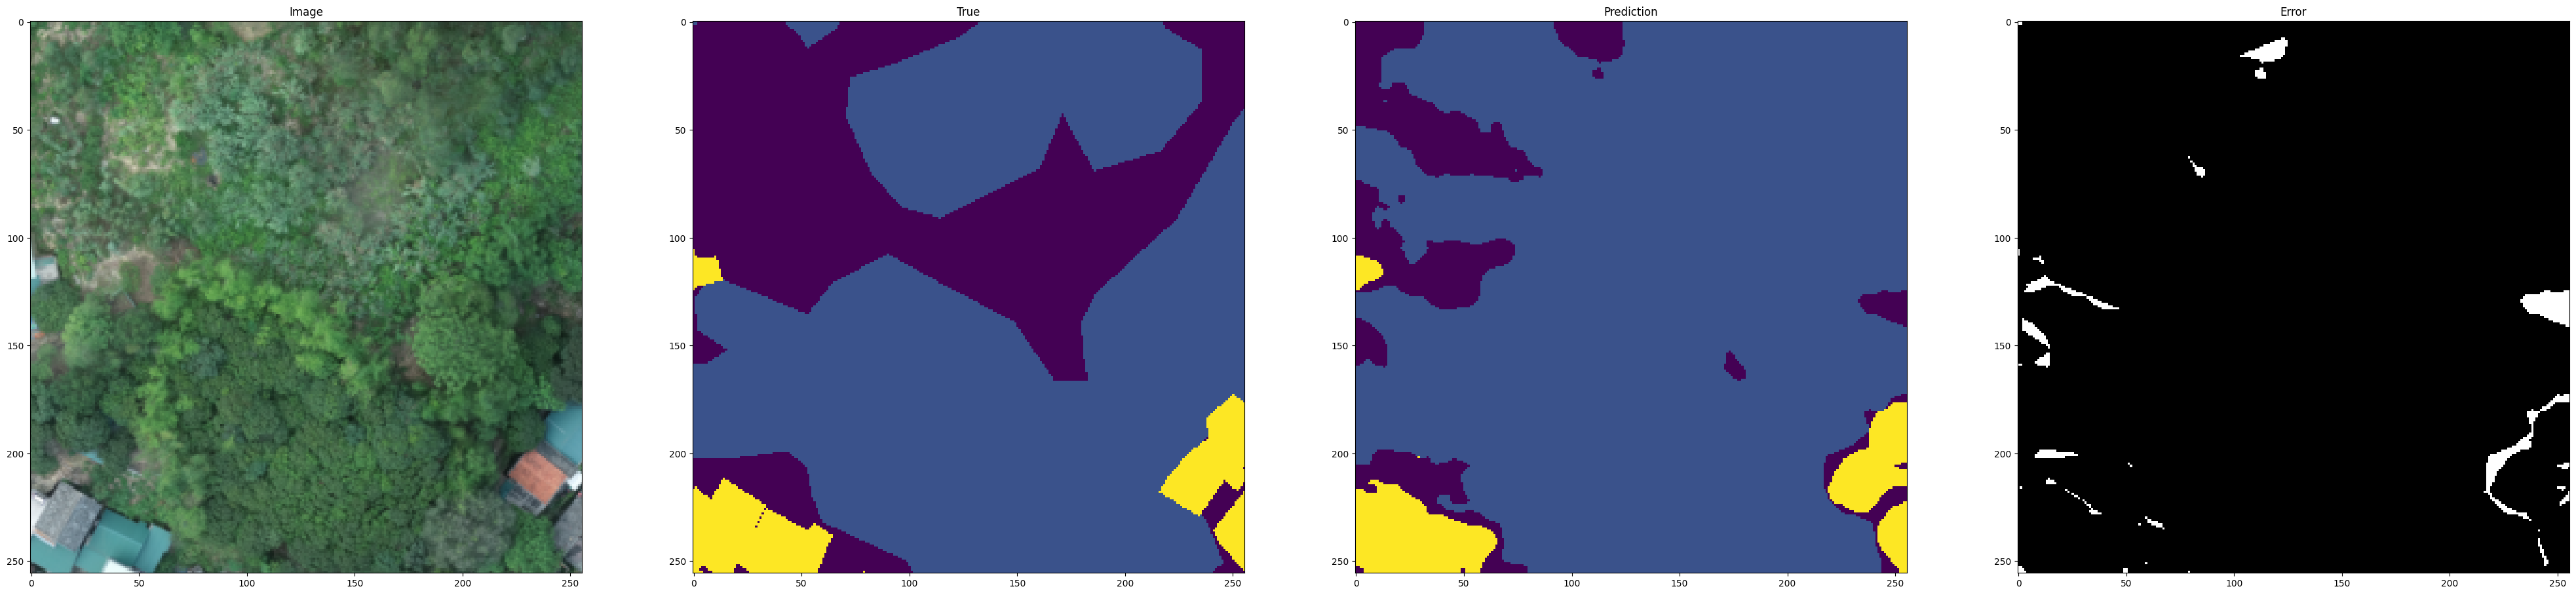

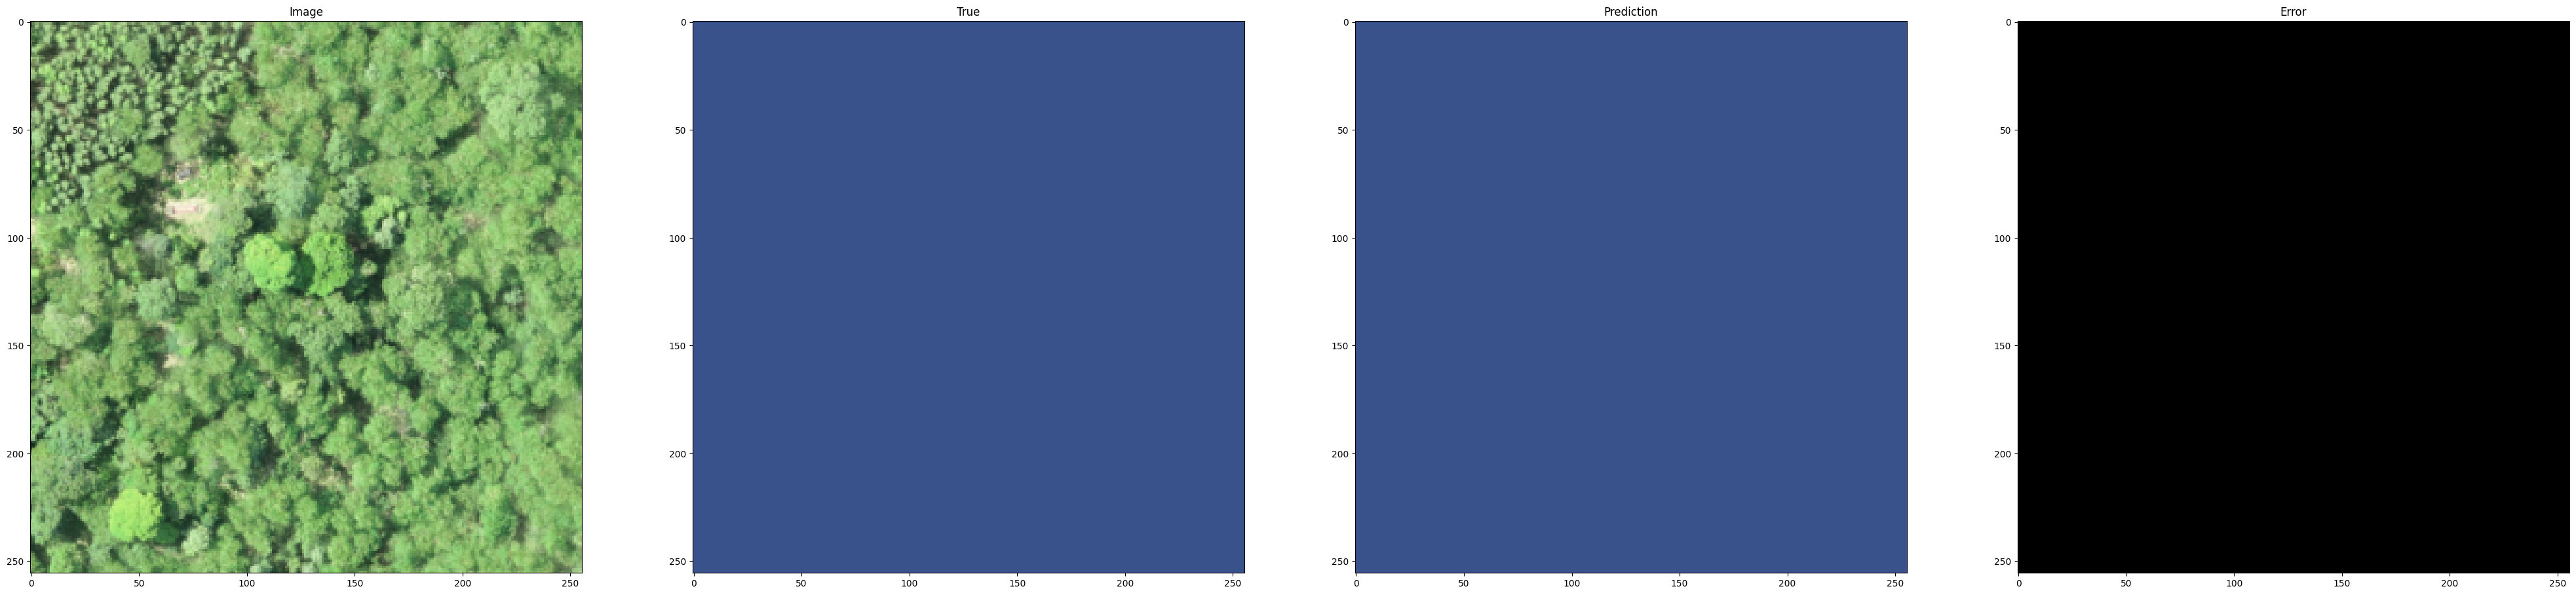

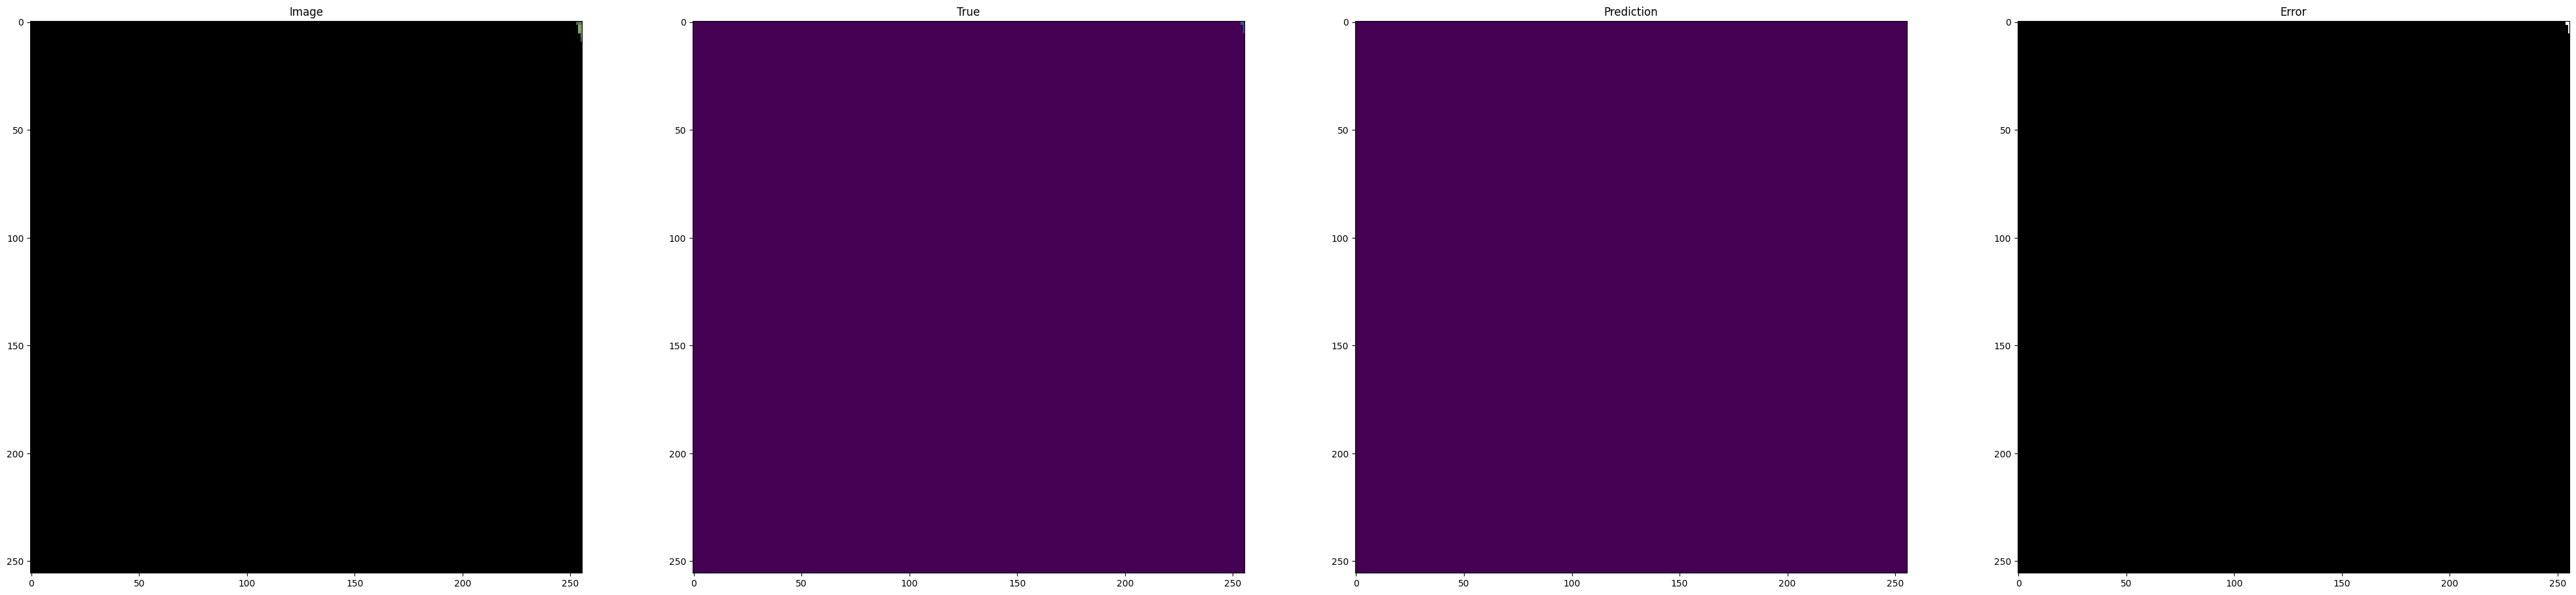

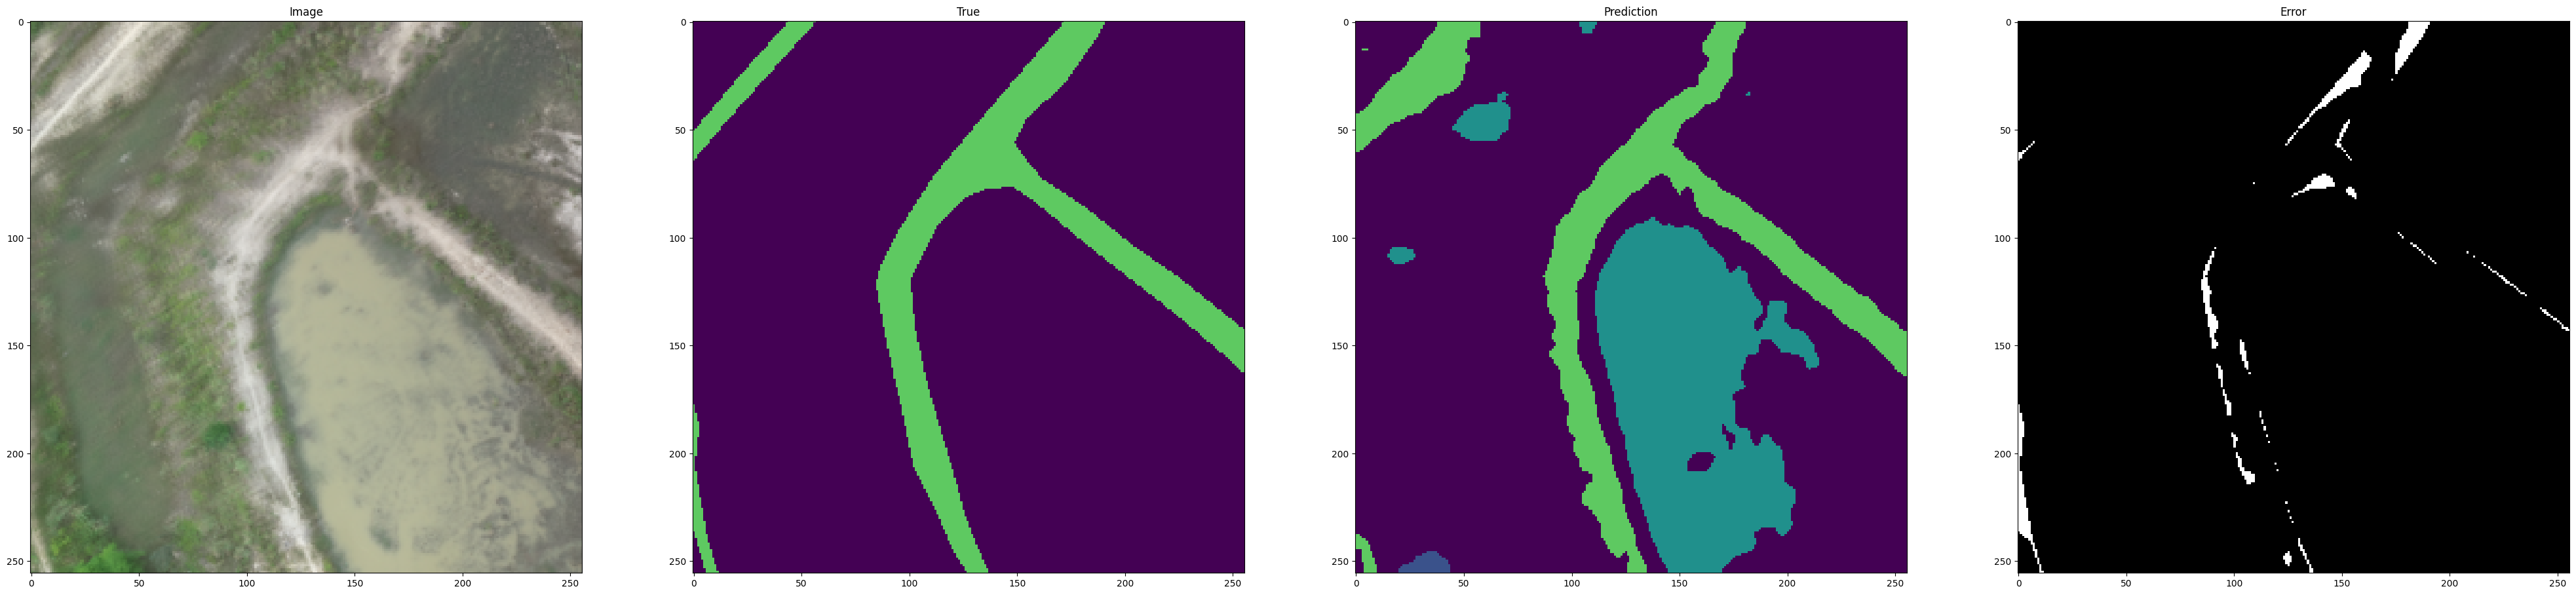

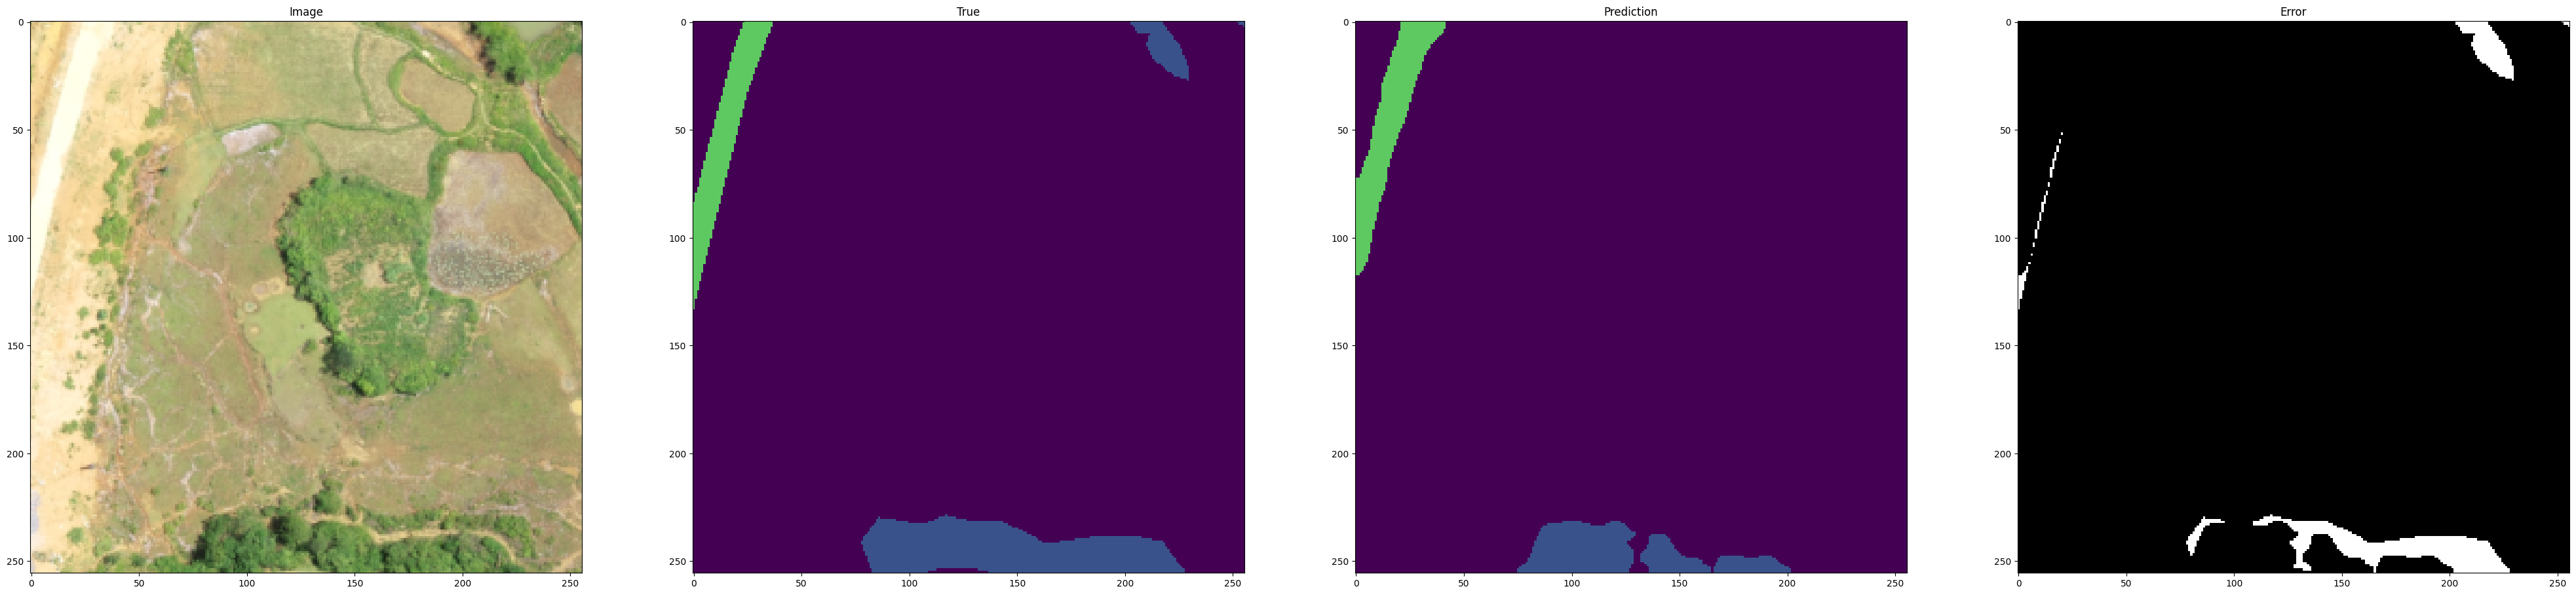

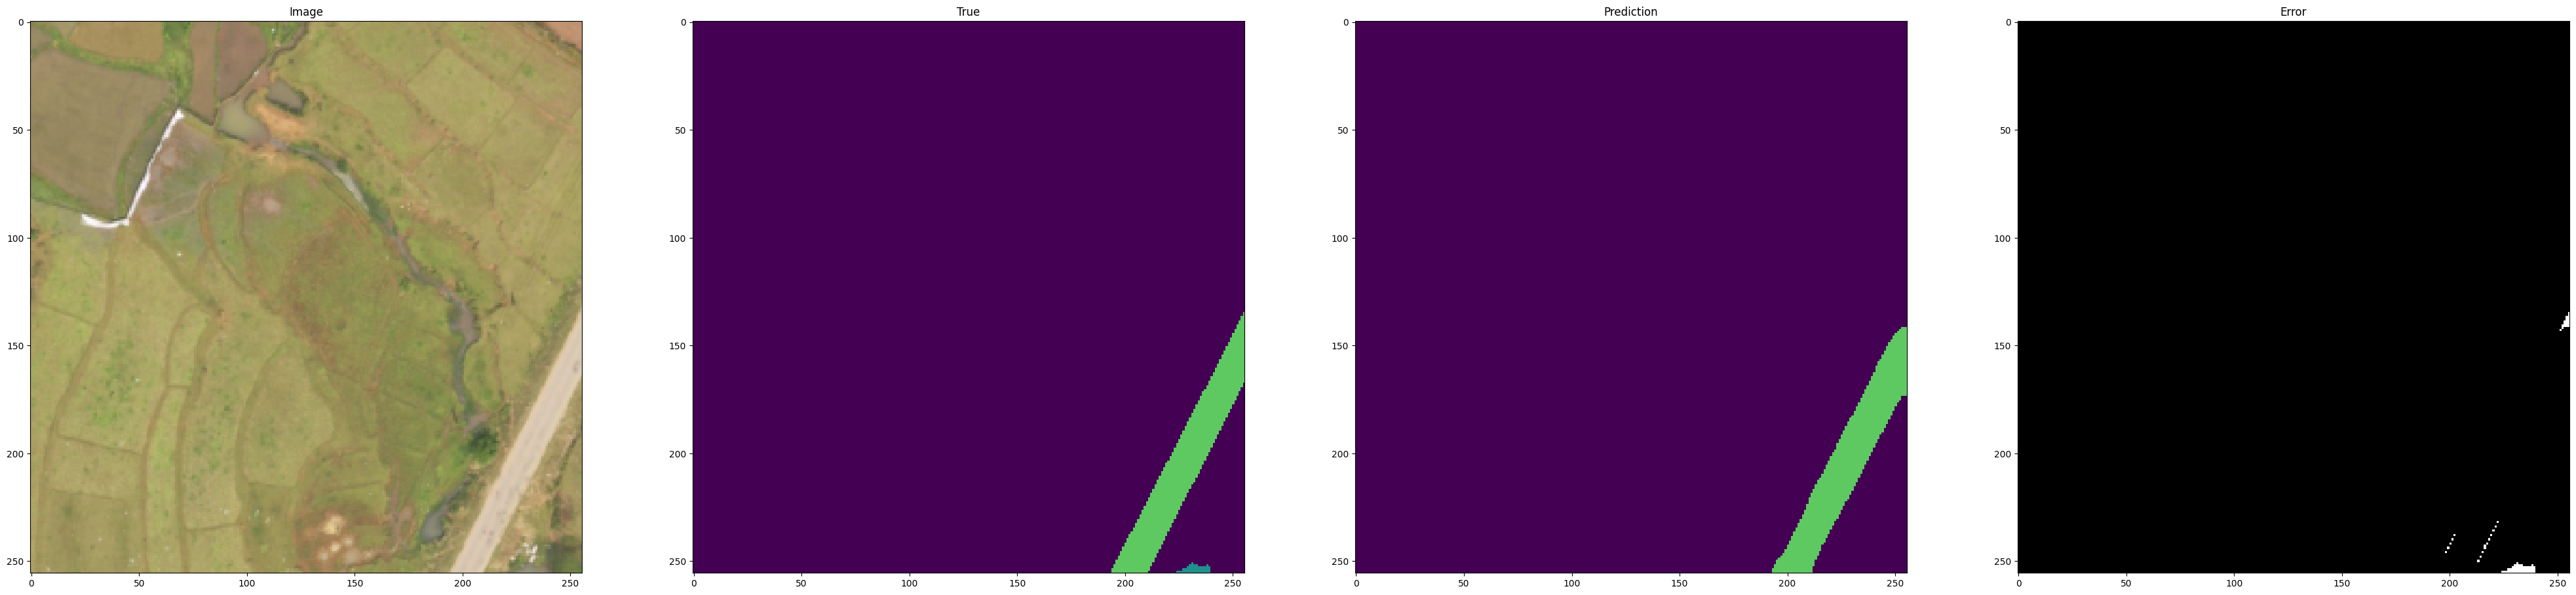

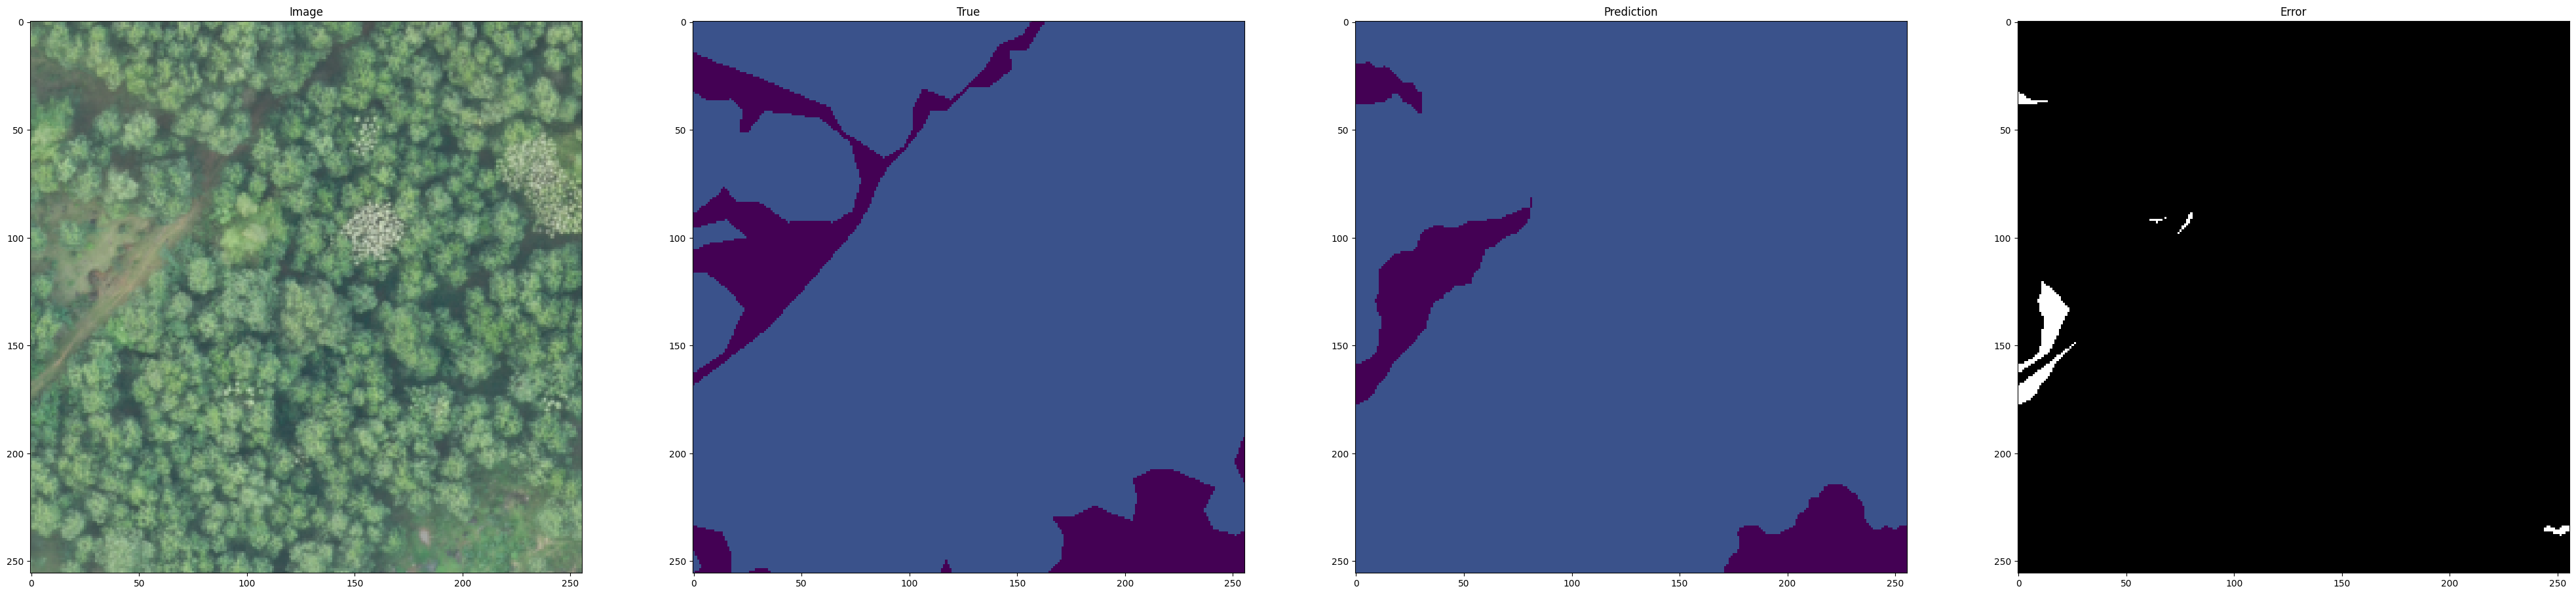

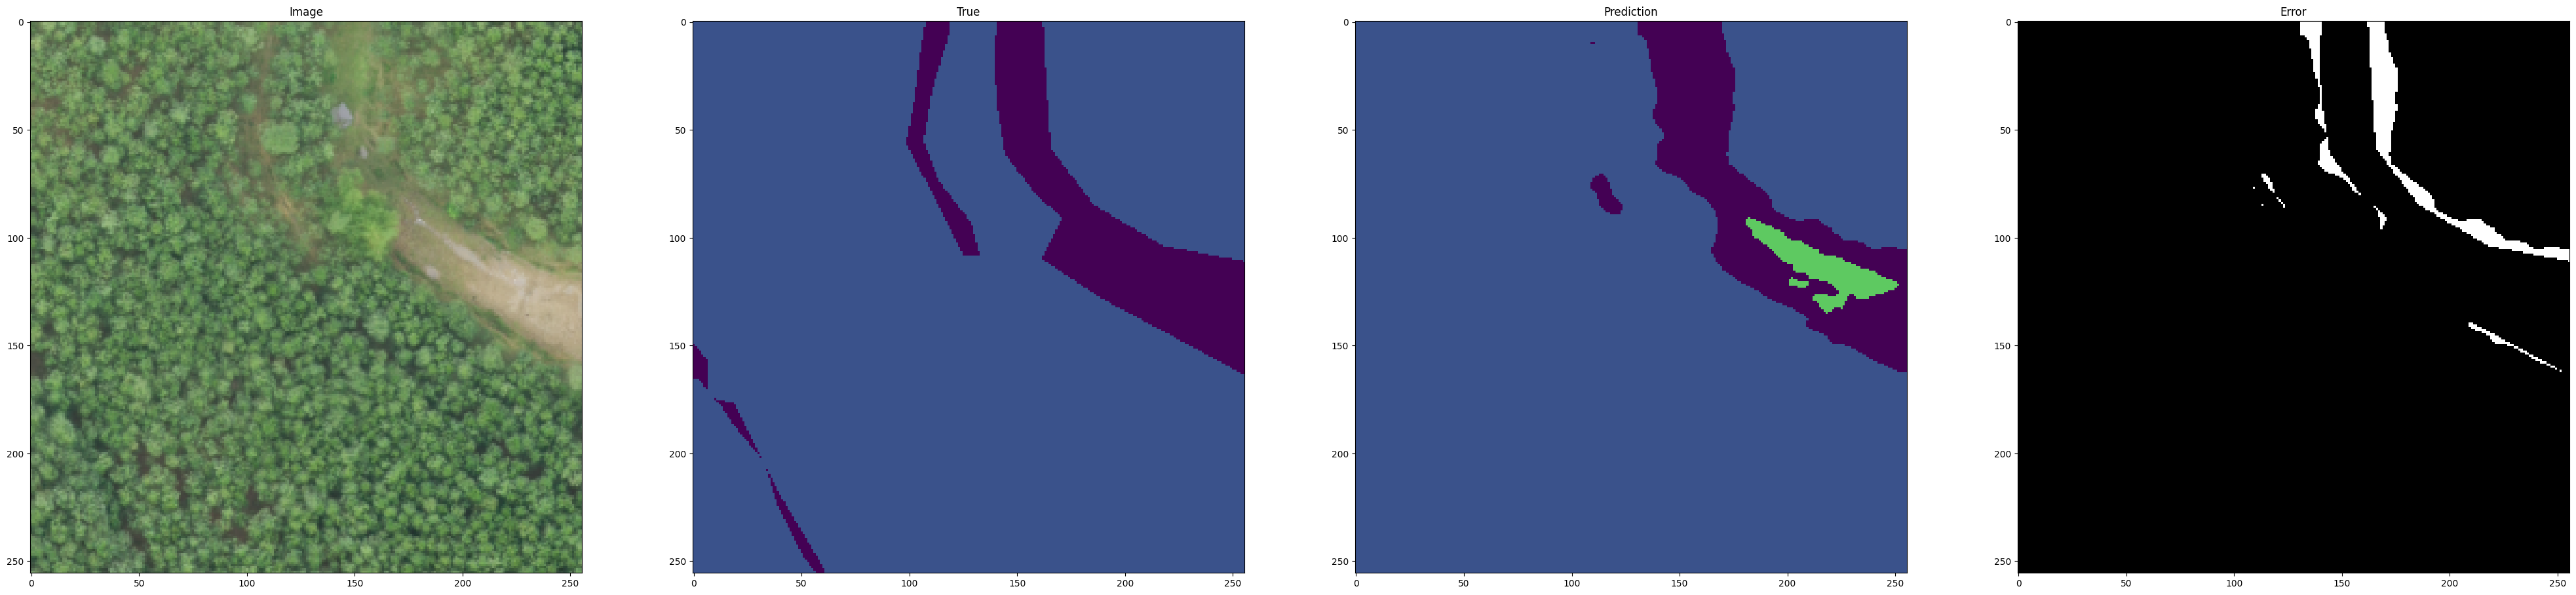

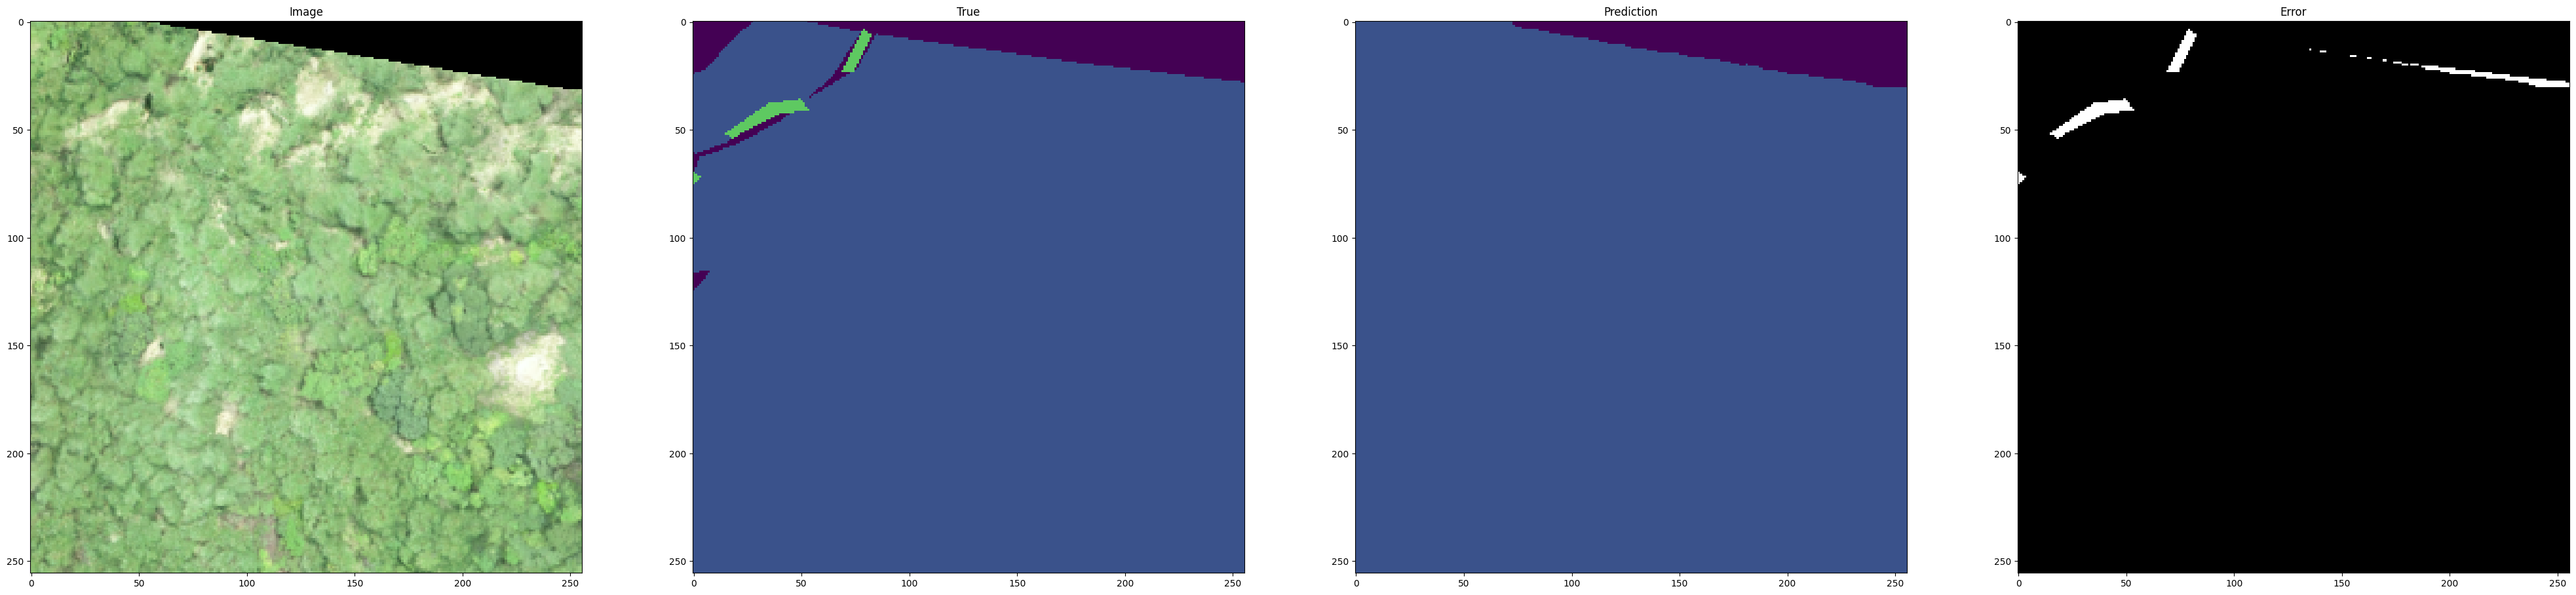

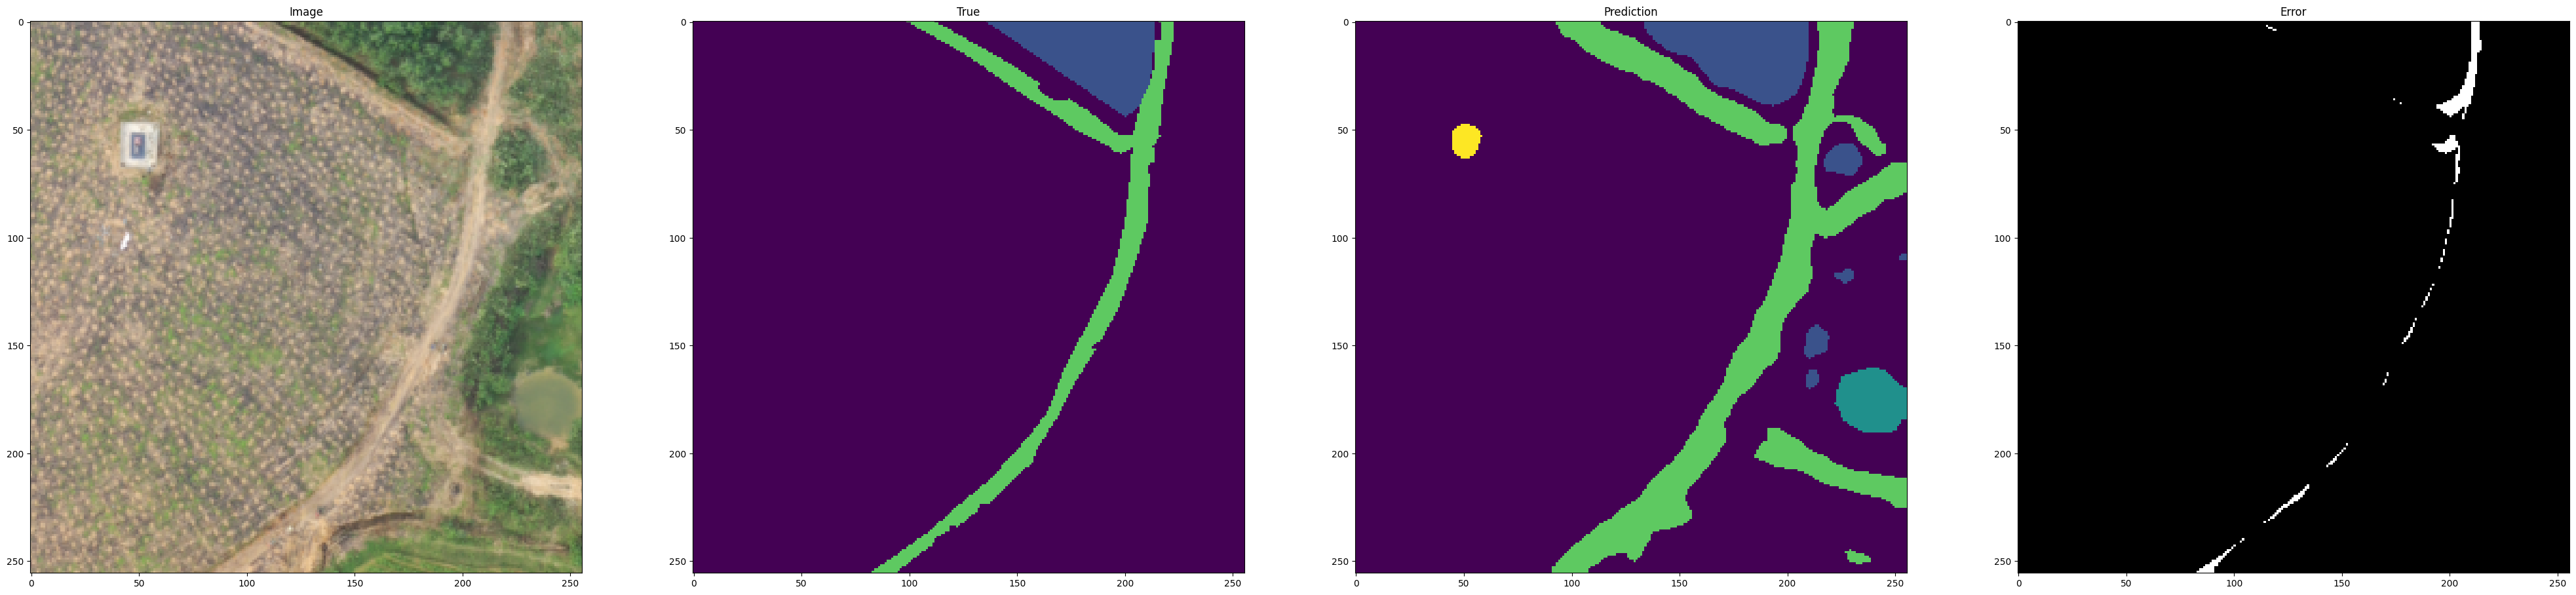

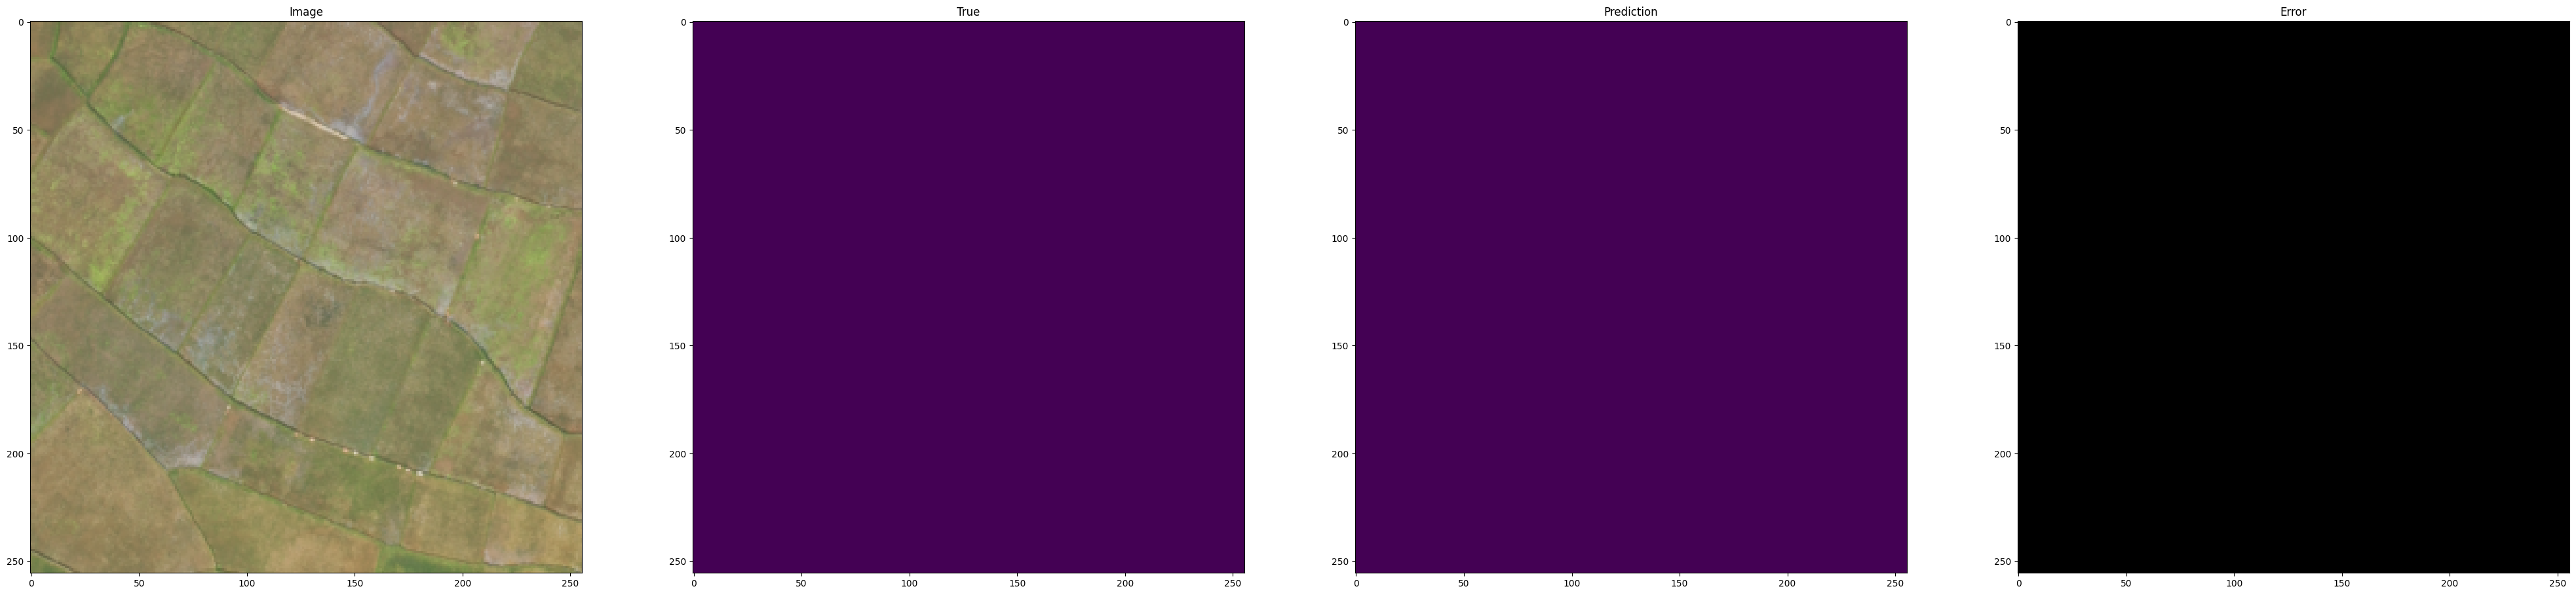

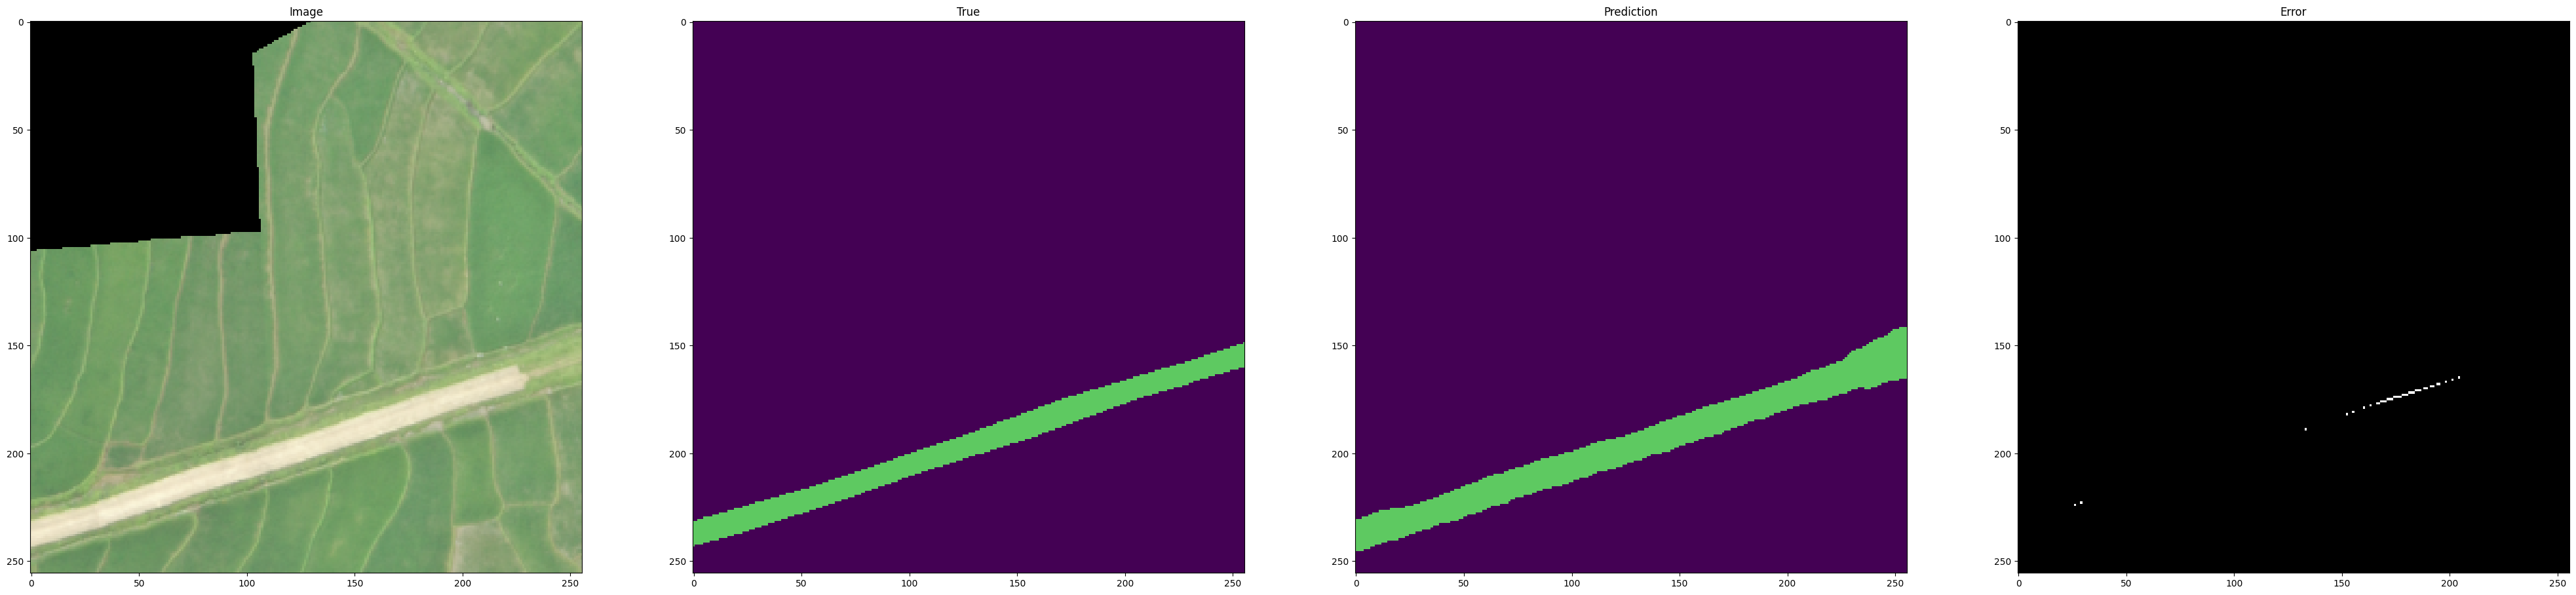

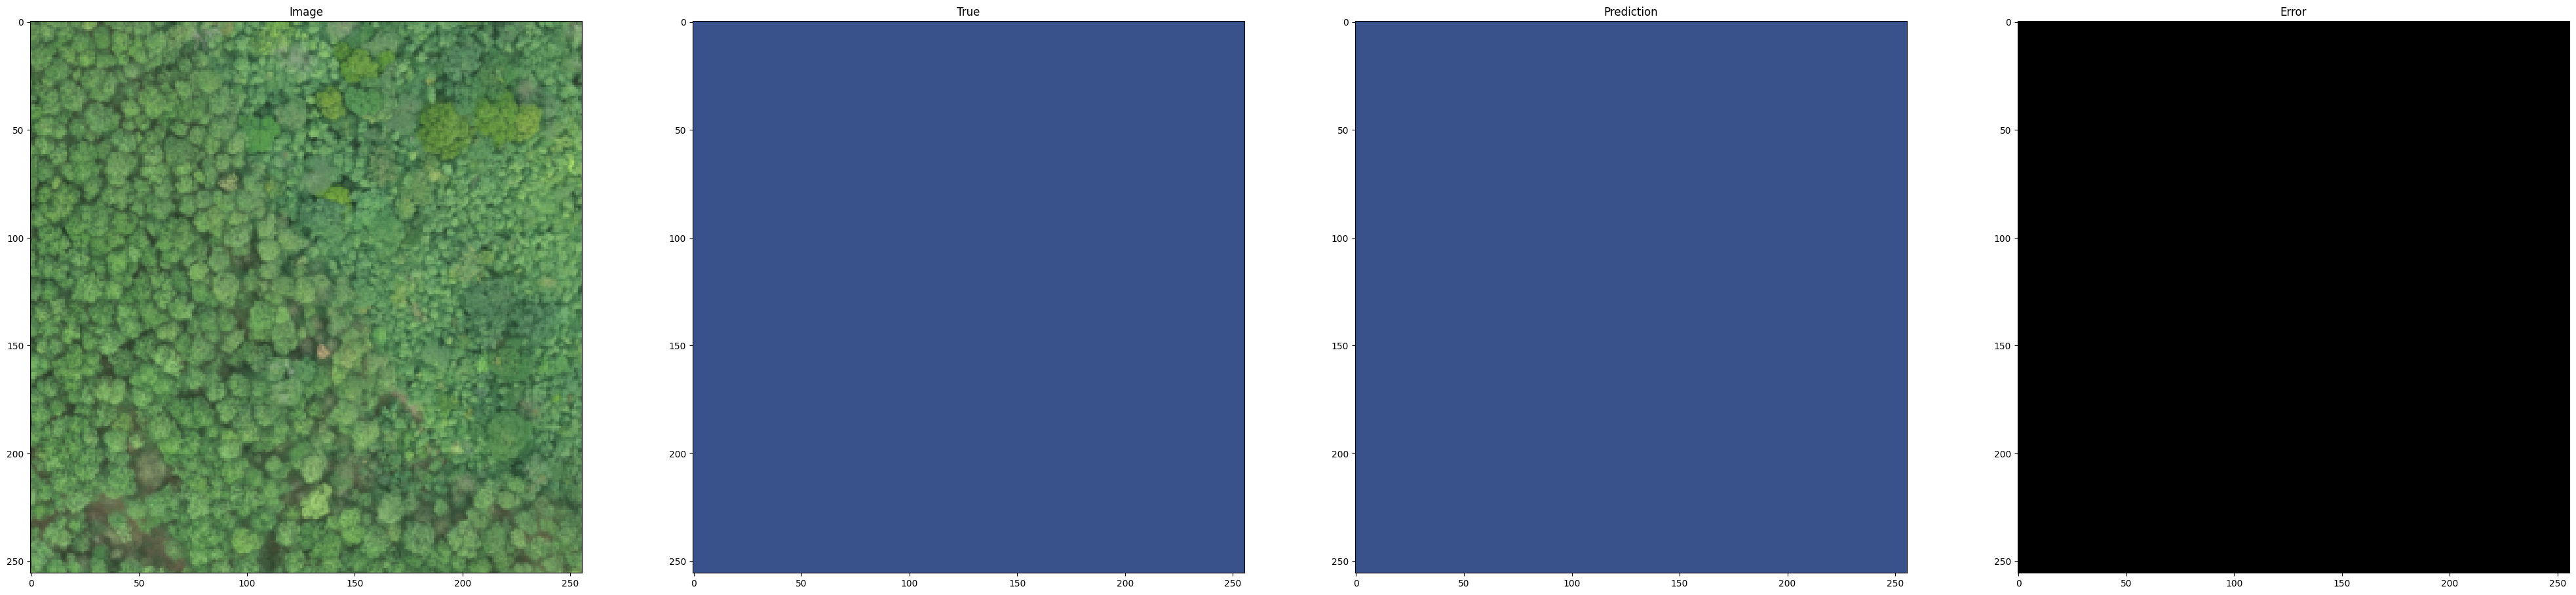

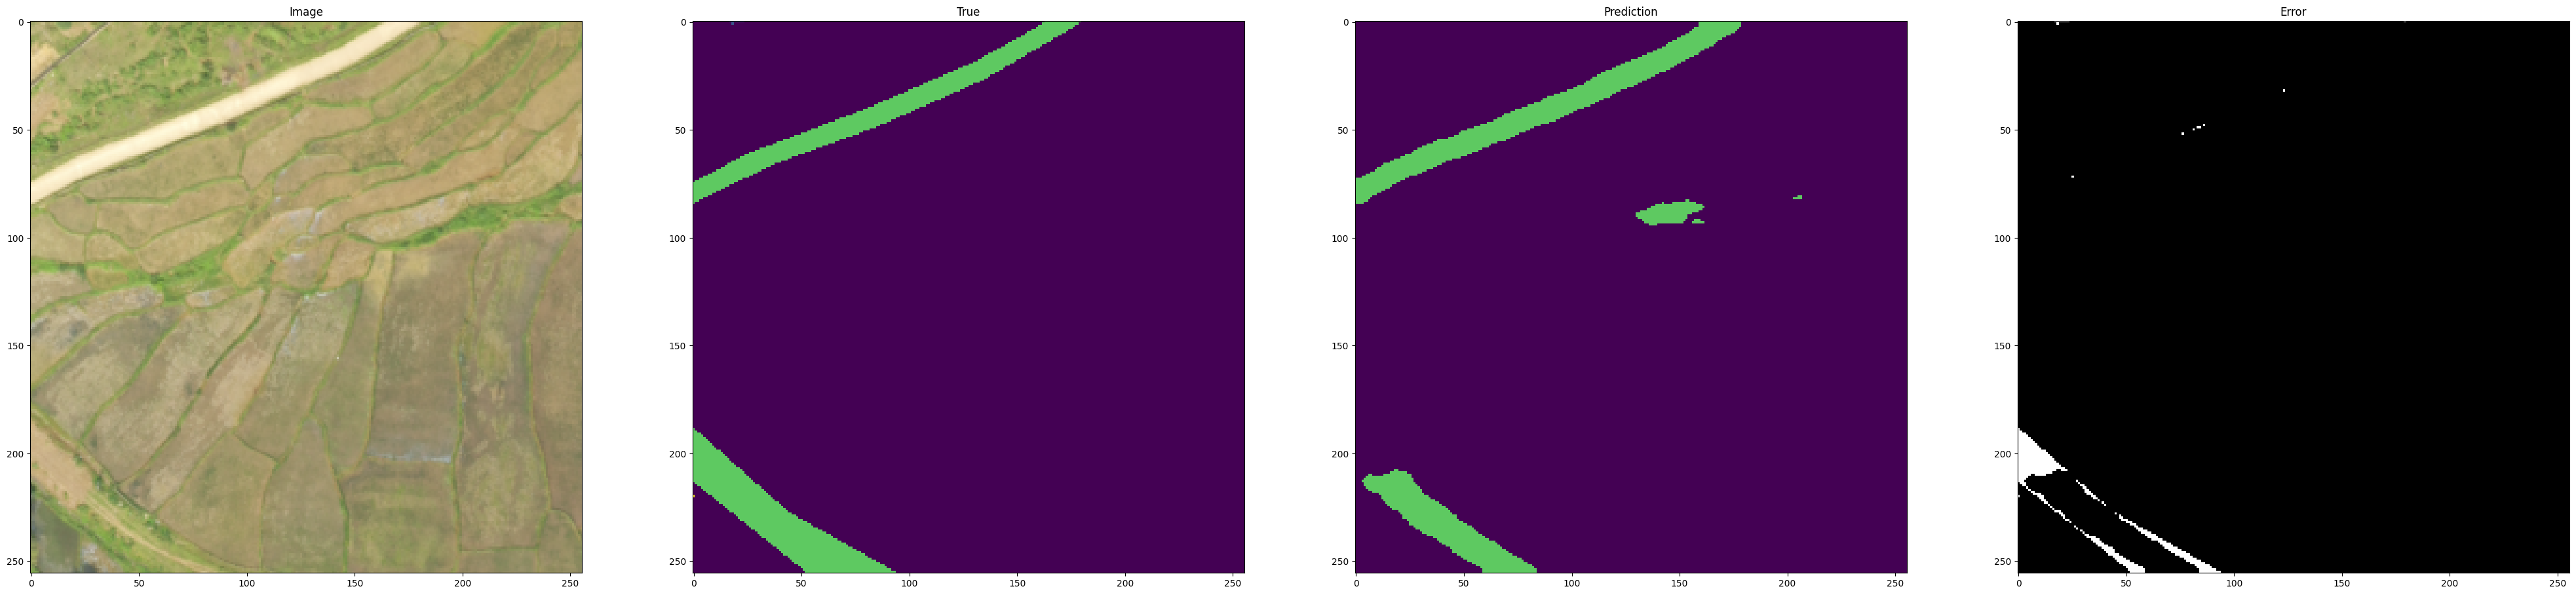

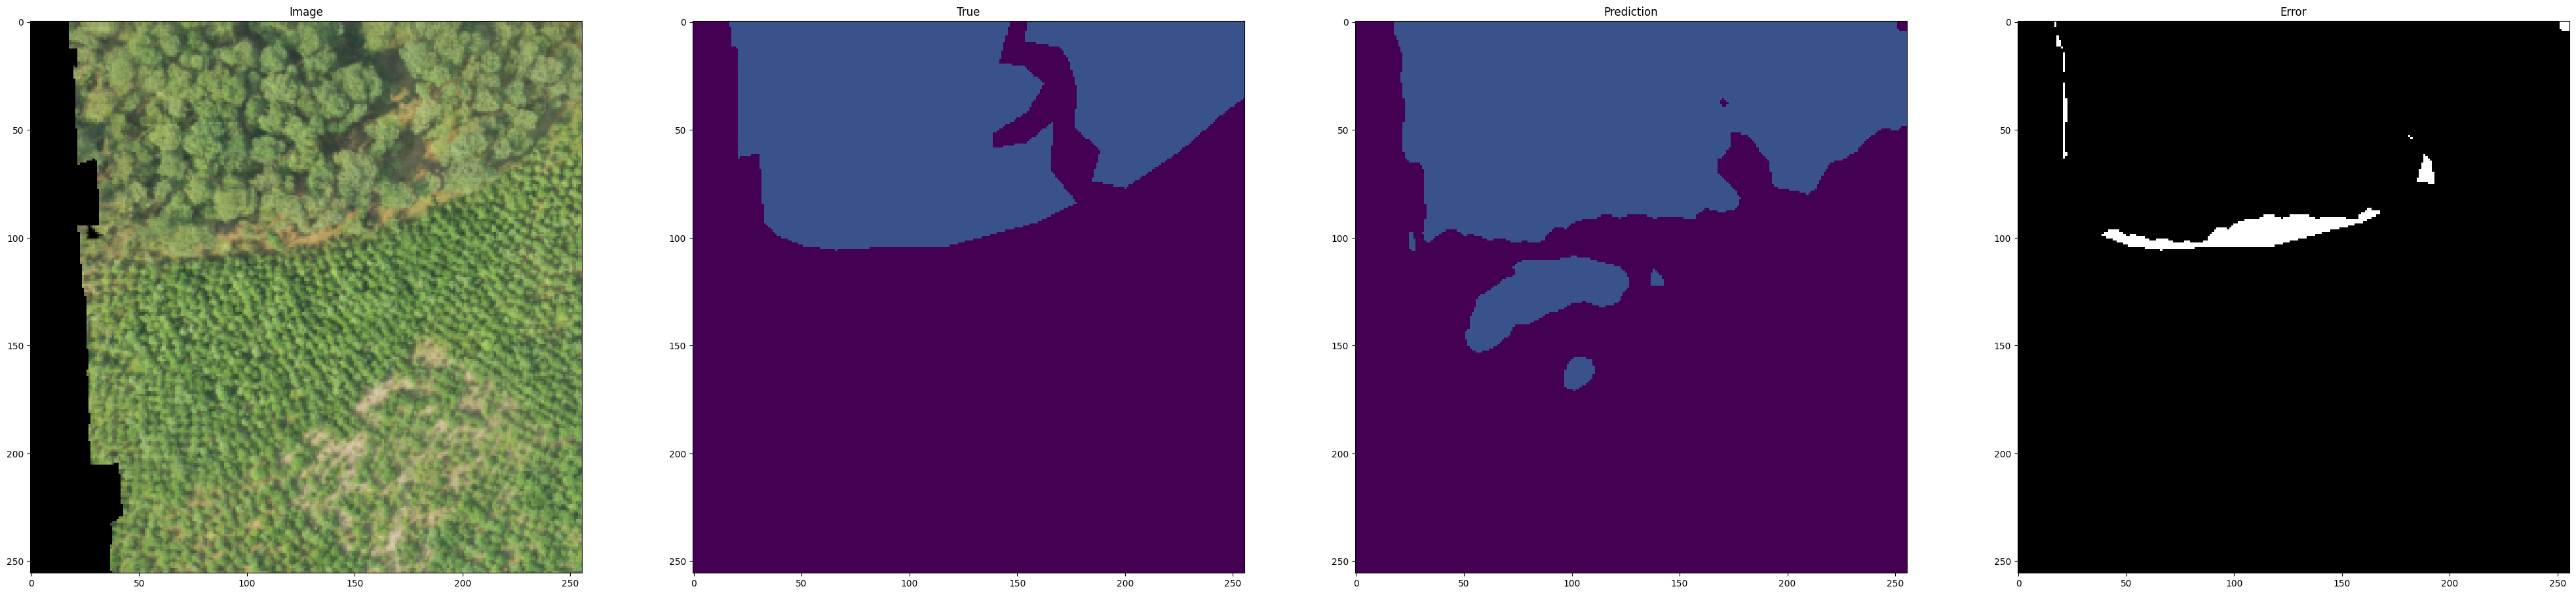

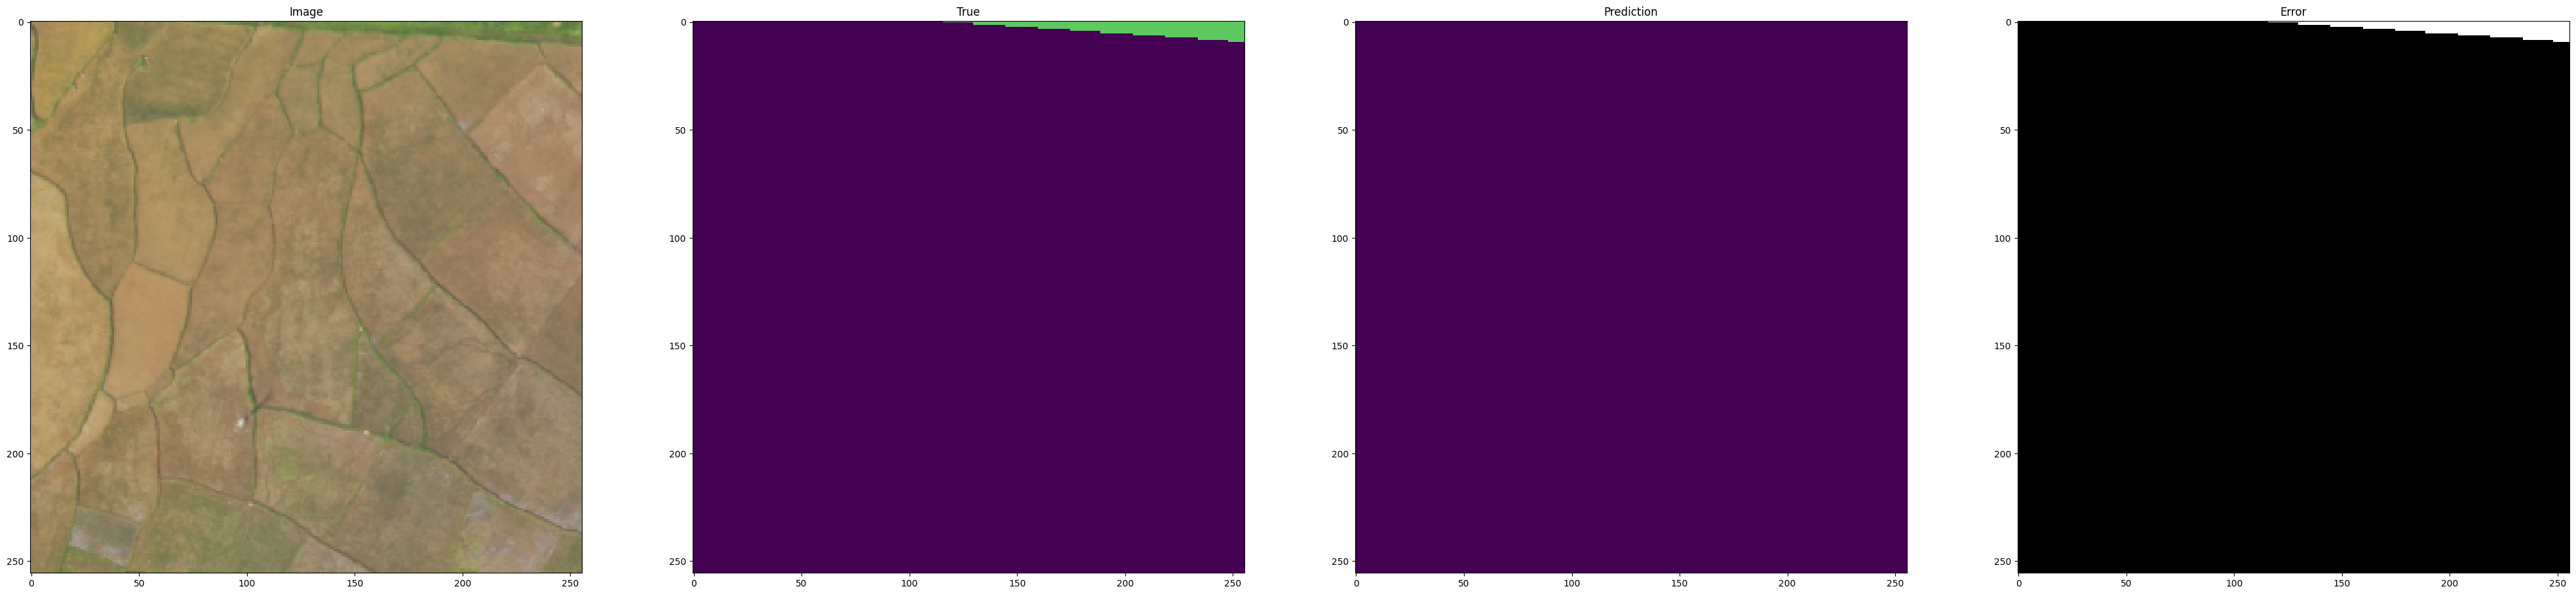

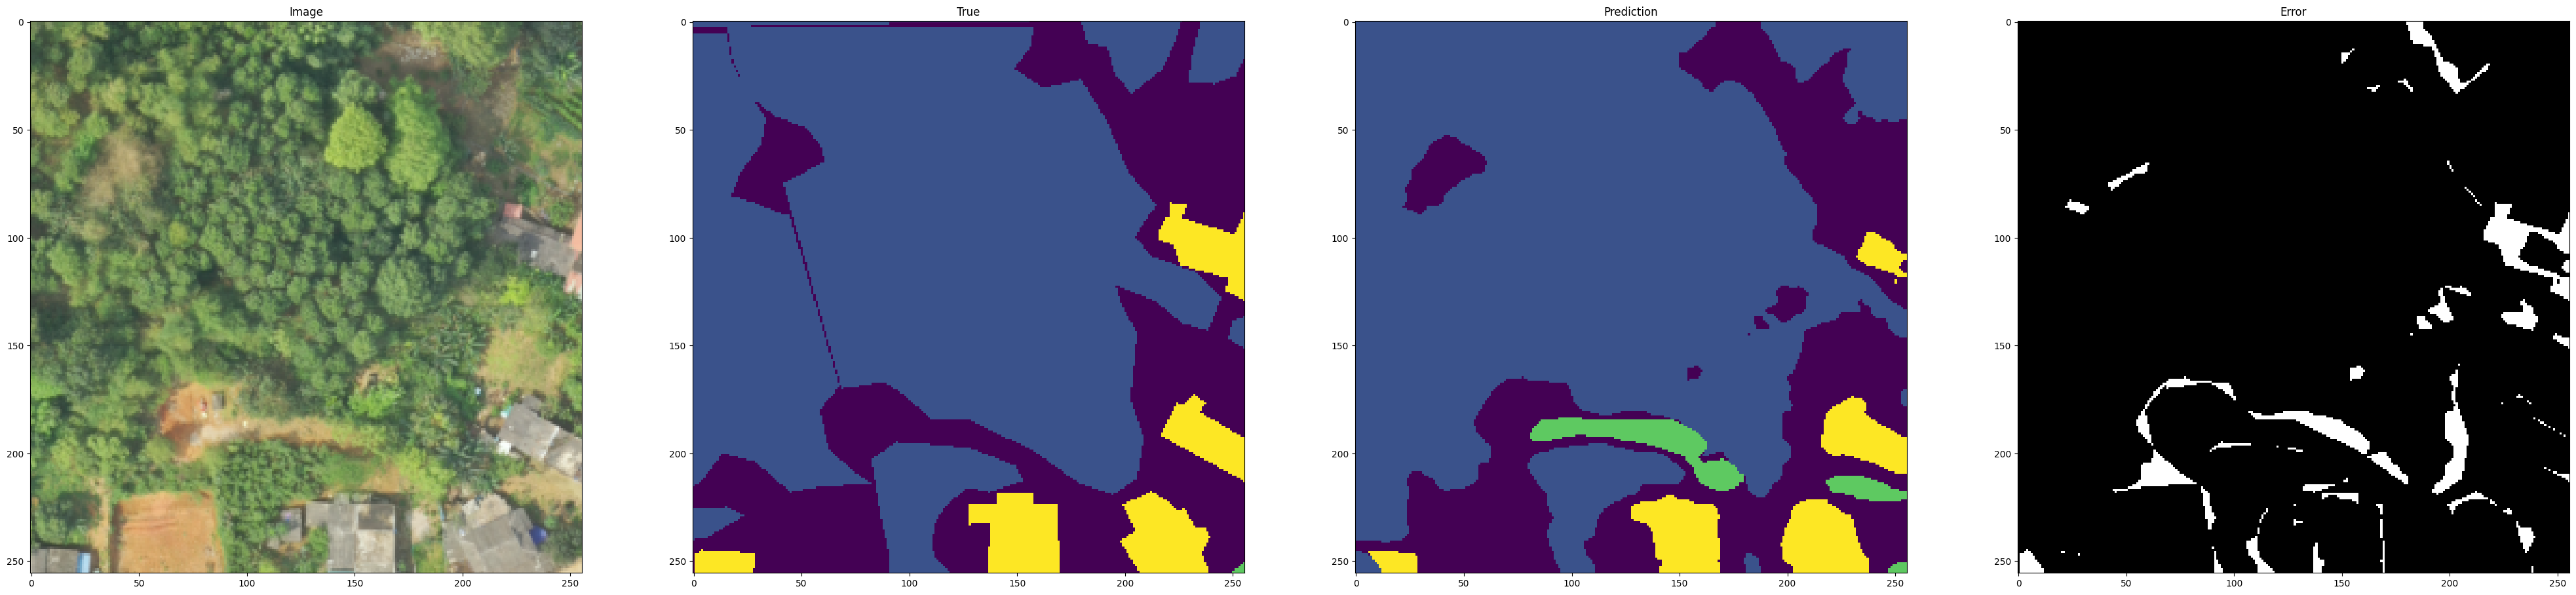

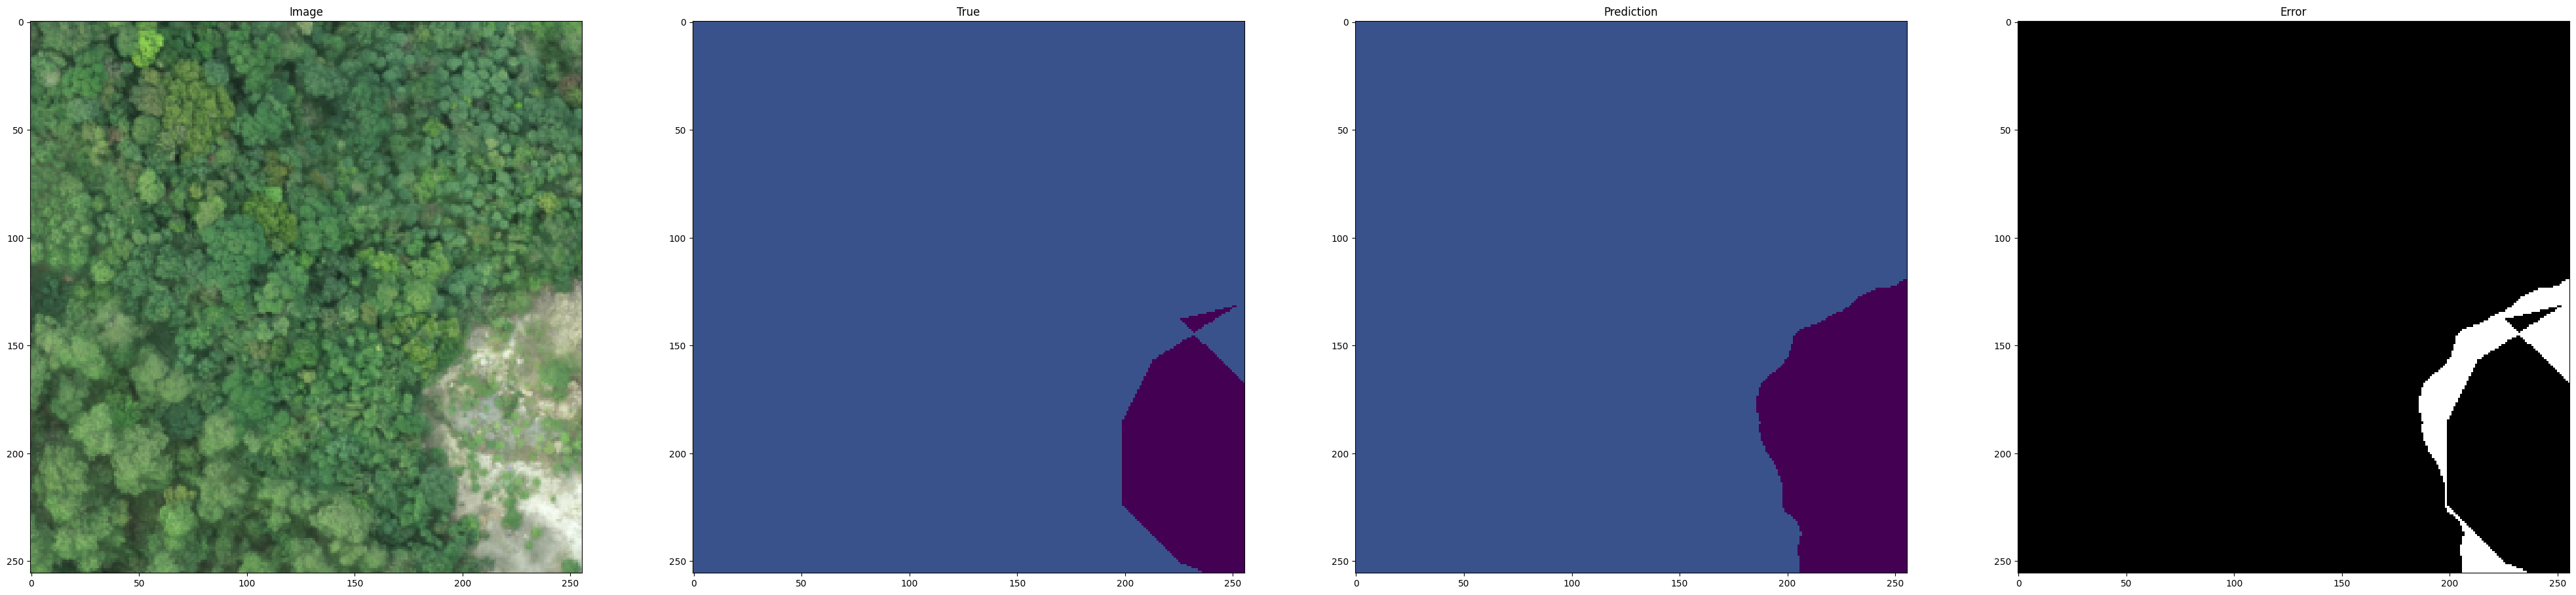

In [ ]:
vmin = 0
vmax = 4

for i in range(20):

    image_number = random.randint(0, X_test.shape[0] - 1)

    plt.figure(figsize=(50, 12.5))

    plt.subplot(141)
    plt.title('Image')
    plt.imshow(X_test[image_number])

    plt.subplot(142)
    plt.title('True')
    true = y_test[image_number].argmax(axis=2)
    plt.imshow(true, vmin = vmin, vmax = vmax)

    plt.subplot(143)
    plt.title('Prediction')
    prediction = model.predict(np.expand_dims(X_test[image_number], 0))[0].argmax(axis=2)  # convert to 0-5 classes

    plt.imshow(prediction, vmin = vmin, vmax = vmax)
    plt.subplot(144)
    plt.title('Error')
    error = (true != prediction) & (true != 0)
    error = error.astype('uint8')
    plt.imshow(error, cmap='gray')

    # print(prediction.shape)
    # print(prediction)
    # print(true.shape)
    # print(true)


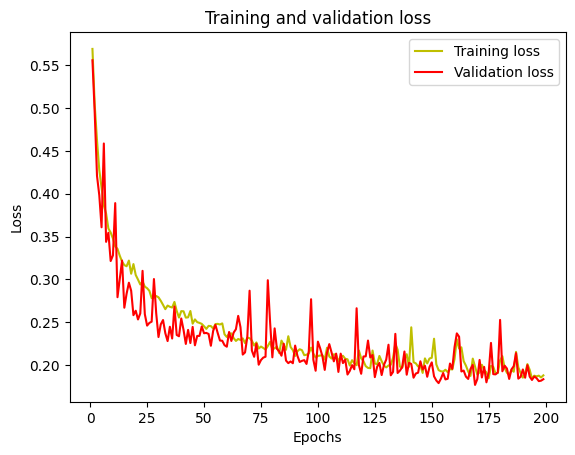

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

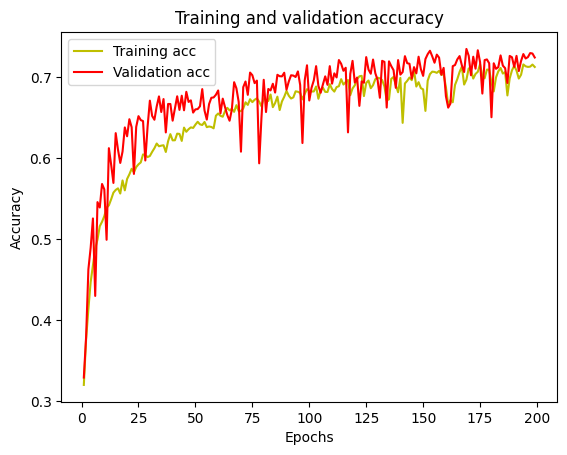

In [ ]:
acc = history.history['iou_score']
val_acc = history.history['val_iou_score']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
# model.save('diceloss_segformer.keras')

In [ ]:
X_pred = []
X_label = []
for i in range(len(X_test)):
  true = y_test[i].argmax(axis=2)
  prediction = model.predict(np.expand_dims(X_test[i], 0))[0].argmax(axis=2)
  X_pred.append(prediction)
  X_label.append(true)

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step


In [ ]:
X_label = np.array(X_label)
X_pred = np.array(X_pred)

In [ ]:
def calculate_iou(y_true, y_pred):
    num_classes = np.max(y_true) + 1  # Number of classes (assuming class indices start from 0)
    iou_scores = []

    for class_id in range(num_classes):
        true_mask = y_true == class_id
        pred_mask = y_pred == class_id

        intersection = np.logical_and(true_mask, pred_mask).sum()
        union = np.logical_or(true_mask, pred_mask).sum()

        if union == 0:
            iou_scores.append(0.0)  # Handle the case of no instances of a class
        else:
            iou_scores.append(intersection / union)

    return np.mean(iou_scores)

In [ ]:
def calculate_iou_for_each_class(y_true, y_pred):
    num_classes = np.max(y_true) + 1  # Number of classes (assuming class indices start from 0)
    iou_scores = {}

    for class_id in range(num_classes):
        true_mask = y_true == class_id
        pred_mask = y_pred == class_id

        intersection = np.logical_and(true_mask, pred_mask).sum()
        union = np.logical_or(true_mask, pred_mask).sum()

        if union == 0:
            iou_scores[class_id] = 0.0  # Handle the case of no instances of a class
        else:
            iou_scores[class_id] = intersection / union

    return iou_scores


iou_scores = calculate_iou_for_each_class(X_label, X_pred)
for class_id, iou in iou_scores.items():
    print("IoU for class", class_id, ":", iou)


IoU for class 0 : 0.8509376715388365
IoU for class 1 : 0.8677713613431716
IoU for class 2 : 0.9073234458412892
IoU for class 3 : 0.5398062018749076
IoU for class 4 : 0.7055604485000815


In [ ]:
miou = calculate_iou(X_label, X_pred)
print("Mean IoU:", miou)

Mean IoU: 0.7742798258196573
